# Covariance Analysis with DELFI-C3
## Objectives
This example will guide you through the set-up of an orbit estimation routine, which usually comprises the **estimation of the covariance**, as well as the **estimation of the initial parameters**. In this example we will **focus on the former**, and you'll learn:

* how to **set up the estimation** of a covariance matrix;
* how to **plot the correlation coefficients**;
* how to **plot the uncertainty ellipsoids**.

For the **full estimation** of some selected parameteres, such as initial state, drag coefficient, and radiation pressure coefficient of a spacecraft, see [DELFI-C3 - Parameter Estimation Example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/full_estimation_example.html).

To simulate the orbit of a spacecraft, we will fall back and reiterate on all aspects of orbit propagation that are important within the scope of orbit estimation. Further, we will highlight all relevant features of modelling a tracking station on Earth. Using this station, we will simulate a tracking routine of the spacecraft using a series of instantaneous unbiased one-way Doppler range-rate measurements with uncertainty of 1 mm/s every 60 seconds. To assure an uninterrupted line-of-sight between the station and the spacecraft, a minimum elevation angle of more than 15 degrees above the horizon - as seen from the station - will be imposed as constraint on the simulation of observations.

The first part of this example deals with the setup of all relevant (environment, propagation, and estimation) modules, so feel free to skip these steps if you're already familiar with them!

## Key API References
 Here's a comprehensive list of the  _modules_ and _methods_ that are relevant to this example, or that will be introduced here for the first time.

| Module | | Methods |➡️ | | | 
| --- | --- | --- | --- | --- | --- |
| [numerical_simulation.estimation_setup.observation](https://py.api.tudat.space/en/latest/observation.html) | [**body_reference_point_link_end_id**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.body_reference_point_link_end_id) | [**LinkDefinition**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.LinkDefinition) | [**one_way_doppler_instantaneous**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.one_way_doppler_instantaneous) | [**add_gaussian_noise_to_observable**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.add_gaussian_noise_to_observable) | [**elevation_angle_viability**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.elevation_angle_viability) |[**tabulated_simulation_settings**](https://py.api.tudat.space/en/latest/observation.html#tudatpy.numerical_simulation.estimation_setup.observation.tabulated_simulation_settings)|
| [numerical_simulation.estimation_setup](https://py.api.tudat.space/en/latest/estimation_setup.html)|[**parameter**](https://py.api.tudat.space/en/latest/parameter.html)  |[**create_parameter_set**](https://py.api.tudat.space/en/latest/estimation_setup.html#tudatpy.numerical_simulation.estimation_setup.create_parameter_set) | | | | |
| [numerical_simulation.Estimator](https://py.api.tudat.space/en/latest/numerical_simulation.html#tudatpy.numerical_simulation.Estimator)  | [**observation_simulators**](https://py.api.tudat.space/en/latest/numerical_simulation.html#tudatpy.numerical_simulation.Estimator.observation_simulators) | [**compute_covariance**](https://py.api.tudat.space/en/latest/numerical_simulation.html#tudatpy.numerical_simulation.Estimator.compute_covariance) | [**perform_estimation**](https://py.api.tudat.space/en/latest/numerical_simulation.html#tudatpy.numerical_simulation.Estimator.perform_estimation) | [**state_transition_interface**](https://py.api.tudat.space/en/latest/numerical_simulation.html#tudatpy.numerical_simulation.Estimator.state_transition_interface) | |
| [numerical_simulation.estimation](https://py.api.tudat.space/en/latest/estimation.html) | [**simulate_observations**](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.simulate_observations) | [**CovarianceAnalysisInput**](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.CovarianceAnalysisInput) | [**estimation_convergence_checker**](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.EstimationConvergenceChecker) |[**EstimationInput**](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.EstimationInput)|
| [astro.time_conversion](https://py.api.tudat.space/en/latest/time_conversion.html) | [**DateTime**]() | 
| [astro.element_conversion](https://py.api.tudat.space/en/latest/element_conversion.html) | [**geodetic_position_type**]() | 


🧐 **Missing something**? You can find out more on the [TudatPy API Reference](https://py.api.tudat.space/en/latest/), or you can [reach out to us](https://docs.tudat.space/en/latest/_src_about/contribute_to_tudat.html)! 

## Import statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `observations` modules will be used and demonstrated within this example.

In [1]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

## Configuration
First, NAIF's `SPICE` kernels are loaded, to make the positions of various bodies such as the Earth, the Sun, or the Moon known to `tudatpy`.

Subsequently, the start and end epoch of the simulation and observations are defined.* Note that using `tudatpy`, the times are generally specified in seconds since J2000. Hence, setting the start epoch to `0` corresponds to the 1st of January 2000. The end epoch specifies a total duration of the simulation of four days.

For more information on J2000 and the conversion between different temporal reference frames, please refer to the API documentation of the [`time_conversion module`](https://tudatpy.readthedocs.io/en/latest/time_conversion.html).

*Please note that it is always a good practice to separate the observation start and end epochs from the simulated ones. This way, we ensure that the times at which the observations are simulated all fall within the simulation timespan, especially given the geometry of the problem and the time difference at the two link ends (receiver and transmitter are separated by a certain distance). For this reason, we will set the first observation start epoch at one day after the simulation start epoch, and the observation end epoch at one day before the end of the simulation.

In [2]:
# Load spice kernels
spice.load_standard_kernels()

# Set simulation start and end epochs
simulation_start_epoch = DateTime(2000, 1, 1).epoch()
simulation_end_epoch   = DateTime(2000, 1, 5).epoch()

observation_start_epoch = DateTime(2000, 1, 2).epoch()
observation_end_epoch   = DateTime(2000, 1, 4).epoch()

## Set up the environment
We will now create and define the settings for the environment of our simulation. In particular, this covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.

### Create the main bodies
To create the systems of bodies for the simulation, one first has to define a list of strings of all bodies that are to be included. Note that the default body settings (such as atmosphere, body shape, rotation model) are taken from the `SPICE` kernel.

These settings, however, can be adjusted. Please refer to the [Available Environment Models](https://tudat-space.readthedocs.io/en/latest/_src_user_guide/state_propagation/environment_setup/create_models/available.html#available-environment-models) in the user guide for more details.

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [3]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

### Create the vehicle and its environment interface
We will now create the satellite - called Delfi-C3 - for which an orbit will be simulated. Using an `empty_body` as a blank canvas for the satellite, we define mass of 400kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, and a aerodynamic drag coefficient of 1.2. Idem for the radiation pressure coefficient. Finally, when setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [4]:
# Create vehicle objects.
body_settings.add_empty_settings("Delfi-C3")
body_settings.get("Delfi-C3").constant_mass = 400 

# Create aerodynamic coefficient interface settings
reference_area = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0.0, 0.0]
)
# Add the aerodynamic interface to the environment
body_settings.get("Delfi-C3").aerodynamic_coefficient_settings = aero_coefficient_settings

# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies = dict()
occulting_bodies["Sun"] = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies)

# Add the radiation pressure interface to the environment
body_settings.get("Delfi-C3").radiation_pressure_target_settings = radiation_pressure_settings

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

## Set up the propagation
Having the environment created, we will define the settings for the propagation of the spacecraft. First, we have to define the body to be propagated - here, the spacecraft - and the central body - here, Earth - with respect to which the state of the propagated body is defined.

In [5]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
Subsequently, all accelerations (and there settings) that act on `Delfi-C3` have to be defined. In particular, we will consider:
* Gravitational acceleration using a spherical harmonic approximation up to 8th degree and order for Earth.
* Aerodynamic acceleration for Earth.
* Gravitational acceleration using a simple point mass model for:
    - The Sun
    - The Moon
    - Mars
* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to `Delfi-C3` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [6]:
# Define the accelerations acting on Delfi-C3
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

# Create global accelerations dictionary
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
In Tudat, the initial state of the spacecraft always has to be provided as a **cartesian state** - i.e. in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of Delfi-C3 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [space-track.org](https://www.space-track.org) and are converted in to cartesian state via the `cartesian_state`function of the `ephemeris` class. 

In [7]:
# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68"
)
delfi_ephemeris = environment.TleEphemeris( "Earth", "J2000", delfi_tle, False )
initial_state = delfi_ephemeris.cartesian_state( simulation_start_epoch )

### Create the integrator settings
For the problem at hand, we will use an RKF78 integrator with a **fixed step-size of 60 seconds**. This can be achieved by tweaking the implemented RKF78 integrator with variable step-size such that both the minimum and maximum step-size is equal to 60 seconds and a tolerance of 1.0

In [8]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Create the propagator settings
By combining all of the above-defined settings we can define the settings for the propagator to simulate the orbit of `Delfi-C3` around Earth. A **termination condition** needs to be defined so that the propagation stops as soon as the specified end epoch is reached. Finally, the translational propagator's settings are created.

In [9]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

## Set up the observations
Having set the underlying dynamical model of the simulated orbit, we can define the **observational model**. Generally, this entails the addition of all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.

### Add a ground station
Trivially, the simulation of observations requires the extension of the current environment by at least one observer - a ground station. For this example, we will model a single ground station located in Delft, Netherlands, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found in the respective [API documentation](https://tudatpy.readthedocs.io/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.add_ground_station).

In [10]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Links and Types
To establish the links between our ground station and `Delfi-C3`, we will make use of the [observation module](https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. During the link definition, each member is assigned a certain function within the link, for instance as "transmitter", "receiver", or "reflector". Once two (or more) members are connected to a link, they can be used to simulate observations along this particular link. The precise type of observation made along this link - e.g., range, range-rate, angular position, etc. - is then determined by the chosen observable type.

To fully define an observation model for a given link, we have to create a list of the observation model settings of all desired observable types and their associated links. This list will later be used as input to the actual estimator object. 

Each observable type has its own function for creating observation model settings - in this example we will use the `one_way_doppler_instantaneous()` function to model a series of one-way open-loop (i.e. instantaneous) Doppler observations. Realise that the individual observation model settings can also include corrective models or define biases for more advanced use-cases.

Note that the `one_way_doppler_instantaneous()` measurements use the **satellite** as **transmitter** and the **ground station** as **receiver**. 

In [11]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observation.receiver] = observation.body_reference_point_link_end_id("Earth", "TrackingStation")
link_ends[observation.transmitter] = observation.body_origin_link_end_id("Delfi-C3")

# Create observation settings for each link/observable
link_definition = observation.LinkDefinition(link_ends)
observation_settings_list = [observation.one_way_doppler_instantaneous(link_definition)]

### Define Observation Simulation Settings
We now have to define the **times at which observations are to be simulated**. To this end, we will define the settings for the simulation of the individual observations from the previously defined observation models. Bear in mind that these observation simulation settings are not to be confused with the ones to be used when setting up the estimator object, as done just above.

Finally, for each observation model, the observation simulation settings set the times at which observations are simulated and defines the viability criteria and noise of the observation. Realise that the latter is technically not needed within the scope of a covariance analysis but for the sake of completeness (and with eye for the estimation example re-using this code) we have opted to nonetheless include it already.

Note that the actual simulation of the observations requires `Observation Simulators`, which are created automatically by the `Estimator` object. Hence, one cannot simulate observations before the creation of an estimator.

In [12]:
# Define observation simulation times for each link (separated by steps of 1 minute)
observation_times = np.arange(observation_start_epoch, observation_end_epoch, 60.0)
observation_simulation_settings = observation.tabulated_simulation_settings(
    observation.one_way_instantaneous_doppler_type,
    link_definition,
    observation_times
)

# Add noise levels of roughly 1.0E-3 [m/s] and add this as Gaussian noise to the observation
noise_level = 1.0E-3
observation.add_gaussian_noise_to_observable(
    [observation_simulation_settings],
    noise_level,
    observation.one_way_instantaneous_doppler_type
)

# Create viability settings
viability_setting = observation.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
observation.add_viability_check_to_all(
    [observation_simulation_settings],
    [viability_setting]
)

## Set up the estimation
Using the defined models for the environment, the propagator, and the observations, we can finally set the actual presentation up. In particular, this consists of defining all parameter that should be estimated, the creation of the estimator, and the simulation of the observations.

### Defining the parameters to estimate
For this example estimation, we decided to estimate the initial state of `Delfi-C3`, its drag coefficient, and the gravitational parameter of Earth. A comprehensive list of parameters available for estimation is provided at [this link](https://py.api.tudat.space/en/latest/parameter.html).

In [13]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Delfi-C3"))

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

### Creating the Estimator object
Ultimately, the `Estimator` object consolidates all relevant information required for the estimation of any system parameter:
    
    1) the environment (bodies)
    2) the parameter set (parameters_to_estimate)
    3) observation models (observation_settings_list)
    4) dynamical, numerical, and integrator setup (propagator_settings)

Underneath its hood, upon creation, the estimator automatically takes care of setting up the relevant Observation Simulator and Variational Equations which will subsequently be required for the simulation of observations and the estimation of parameters, respectively.

In [14]:
# Create the estimator
estimator = numerical_simulation.Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    propagator_settings)

### Perform the observations simulation
Using the created `Estimator` object, we can perform the simulation of observations by calling its [`simulation_observations()`](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.simulate_observations) function. Note that to know about the time settings for the individual types of observations, this function makes use of the earlier defined observation simulation settings.

In [15]:
# Simulate required observations
simulated_observations = estimation.simulate_observations(
    [observation_simulation_settings],
    estimator.observation_simulators,
    bodies)

<a id='covariance_section'></a>

## Perform the covariance analysis
Having simulated the observations and created the `Estimator` object - containing the variational equations for the parameters to estimate - we have defined everything to conduct the actual estimation. Realise that up to this point, we have not yet specified whether we want to perform a covariance analysis or the full estimation of all parameters. It should be stressed that the general setup for either path to be followed is largely identical up to this point (see, for example, the [full estimation example](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/tudatpy-examples/estimation/full_estimation_example.html)).

### Set up the inversion
To set up the inversion of the problem, we collect all relevant inputs in the form of a covariance input object and define some basic settings of the inversion. Most crucially, this is the step where we can account for different weights - if any - of the different observations, to give the estimator knowledge about the quality of the individual types of observations.

In [16]:
# Create input object for covariance analysis
covariance_input = estimation.CovarianceAnalysisInput(
    simulated_observations)

# Set methodological options
covariance_input.define_covariance_settings(
    reintegrate_variational_equations=False)

# Define weighting of the observations in the inversion
weights_per_observable = {estimation_setup.observation.one_way_instantaneous_doppler_type: noise_level ** -2}
covariance_input.set_constant_weight_per_observable(weights_per_observable)

### Computing the Covariance
Using the just defined inputs, we can ultimately run the computation of our covariance matrix. The formal errors are the square root of the diagonal entries of the covariance matrix. While the first six entries represent the uncertainties in the (cartesian) initial state, the seventh and eighth are the errors associated with the gravitational parameter of Earth and the aerodynamic drag coefficient, respectively.

When dealing with the results of covariance analyses - as a measure of how the estimated variable differs from the 'thought' true value - it is important to stress that the correlation between the parameters is another important aspect to take into consideration.

In [17]:
# Perform the covariance analysis
covariance_output = estimator.compute_covariance(covariance_input)

Calculating residuals and partials 39


In [18]:
# Print the covariance matrix
formal_errors = covariance_output.formal_errors
print(formal_errors)

[4.65818981e-01 2.44146670e-01 2.03033972e-01 2.12257565e-04
 2.58608736e-04 4.79380143e-04 1.71664500e+07 5.65551540e-02]


### Visualizing Correlations 
In particular, correlation describes how the estimate and uncertainty of two parameters are related with each other. Typically, a value of 1.0 indicates entirely correlated elements (thus always present on the diagonal, indicating the correlation of an element with itself), a value of 0.0 indicates perfectly uncorrelated elements.

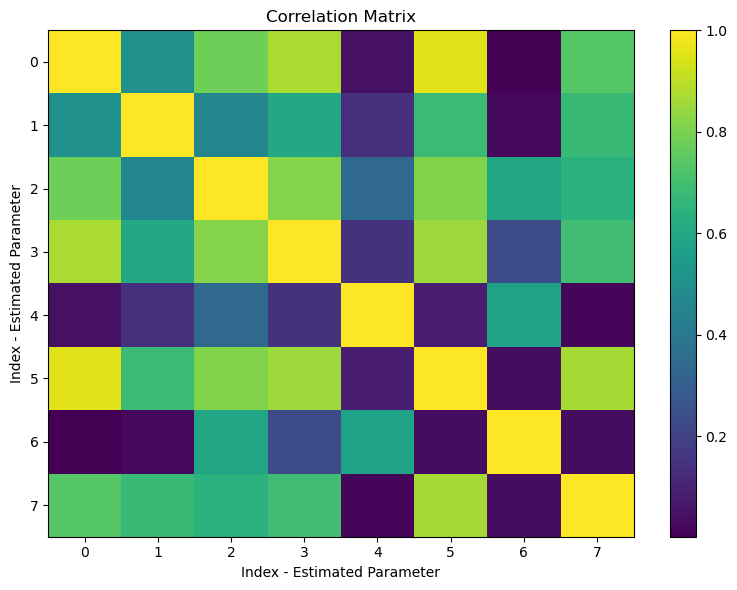

In [19]:
plt.figure(figsize=(8, 6))

plt.imshow((np.abs(covariance_output.correlations)), aspect='auto', interpolation='none')
plt.colorbar()

plt.title("Correlation Matrix")
plt.xlabel("Index - Estimated Parameter")
plt.ylabel("Index - Estimated Parameter")

plt.tight_layout()
plt.show()

## Post-Processing Results
Perfect, we have got our results. Now it is time to make sense of them. To further process them, one can - exemplary - plot:
1) the ellipsoidal confidence region defined by the covariance;
2) the behaviour of the simulated observations over time;
3) the history of the residuals;
4) the statistical interpretation of the final residuals.

### 1) Plotting the Ellipsoidal Confidence Region
The **confidence region** is nothing more than a multi-dimensional generalization of a confidence interval. It is a set of points in an $n$-dimensional space (where $n$ is the number of parameters to be estimated). 
The full confidence region is often represented by its **linear approximation** - the **confidence ellipsoid**, centered in the estimated solution to our problem, also known as "**nominal solution**". This confidence ellipsoid will be **stretched along the direction of the eigenvector corresponding to the most-uncertain parameter**.

It is important to note that, in **nonlinear problems,** the full confidence region will take the form of a **banana**, and the **confidence ellipsoid might not be representative of the real problem anymore**. (See: [Milani & Gronchi, Theory of Orbit Determination](https://www.cambridge.org/core/books/theory-of-orbit-determination/4BBF3B9D3E9DF63268D0733AE4C41C32) for a more detailed explanation.)

In the following, we will see how to plot the **linear approximation of the confidence region**, naming the **confidence ellipsoid**. This is defined by the **covariance matrix**, which also encodes information about the **correlations** between different parameters. Then, we will perform the same operation, taking the "*formal errors matrix*" instead - again, this is the covariance where all the off-diagonal elements are set to zero) - and **we will compare the two ellipsoids** so obtained. 

#### Formal Errors and Covariance Matrix: How Are They Related?
Note how we have mentioned above that the **formal errors** constitute the **diagonal entries of the covariance matrix (variances)**. 
In practice, the "formal error matrix" is a covariance matrix where all the **off-diagonal terms are set to zero**. Recalling what done just above, this amounts discard any **correlation** in the errors between different parameters.

In [20]:
# # Define the parameters
x_star = parameters_to_estimate.parameter_vector # Nominal solution (center of the ellipsoid)
# Create input object for covariance analysis
covariance_input = estimation.CovarianceAnalysisInput(
      simulated_observations)

# # Set methodological options
covariance_input.define_covariance_settings(
     reintegrate_variational_equations=False)
# # Define weighting of the observations in the inversion
covariance_input.set_constant_weight_per_observable(weights_per_observable)
covariance_output = estimator.compute_covariance(covariance_input)
initial_covariance = covariance_output.covariance  # Covariance matrix
print(f'Initial_covariance:\n\n{initial_covariance}\n')

state_transition_interface = estimator.state_transition_interface
output_times = observation_times

diagonal_covariance = np.diag(formal_errors**2)
print(f'Formal Error Matrix:\n\n{diagonal_covariance}\n')

sigma = 3  # Confidence level
original_eigenvalues, original_eigenvectors = np.linalg.eig(initial_covariance)
original_diagonal_eigenvalues, original_diagonal_eigenvectors = np.linalg.eig(diagonal_covariance)
print(f'Estimated state and parameters:\n\n {parameters_to_estimate.parameter_vector}\n')
print(f'Eigenvalues of Covariance Matrix:\n\n {original_eigenvalues}\n')
print(f'Eigenvalues of Formal Errors Matrix:\n\n {original_diagonal_eigenvalues}\n')

Calculating residuals and partials 39
Initial_covariance:

[[ 2.16987323e-01  5.77879311e-02 -7.36539847e-02  8.63012585e-05
   5.78108590e-06  2.13613095e-04  1.71312646e+04  1.94413038e-02]
 [ 5.77879312e-02  5.96075963e-02 -2.27821796e-02  3.12220816e-05
  -8.98478869e-06  7.97570545e-05 -1.00197888e+05  9.37782959e-03]
 [-7.36539848e-02 -2.27821796e-02  4.12227939e-02 -3.53261930e-05
  -1.81135265e-05 -7.88641286e-05 -2.05468359e+06 -7.33123137e-03]
 [ 8.63012586e-05  3.12220816e-05 -3.53261930e-05  4.50532741e-08
  -8.09176789e-09  8.68308764e-08  8.46339071e+02  8.32262311e-06]
 [ 5.78108603e-06 -8.98478864e-06 -1.81135266e-05 -8.09176786e-09
   6.68784782e-08  9.92675216e-09  2.56587435e+03 -2.22061451e-07]
 [ 2.13613095e-04  7.97570545e-05 -7.88641285e-05  8.68308764e-08
   9.92675202e-09  2.29805322e-07  2.78089668e+02  2.34287188e-05]
 [ 1.71312785e+04 -1.00197883e+05 -2.05468359e+06  8.46339076e+02
   2.56587435e+03  2.78089683e+02  2.94687005e+14 -3.53674888e+04]
 [ 1.94413

## Visualizing the covariance and the formal errors
In the following, we will get the **eigenvalues and eigenvectors** corresponding to both the **full covariance matrix** and the **"formal errors matrix"** (i.e. the covariance with only the diagonal elements different from zero). Then, we will show how a unit sphere is stretched by the two matrices ([this website](https://cookierobotics.com/007/) briefly explains how to plot a covariance ellipsoid in two dimensions).

Please note that, in our case, the space of parameters has dimension 8 (initial state + drag coefficient + gravitational parameter), but we will plot the ellipsoid obtained by restricting the problem to the **3 spatial dimensions only** (unless you can find a way to plot an 8D ellipsoid in python!)

The plots will show, for each of the two matrices:
1) the 3-sigma ellipsoid
2) the 1-sigma ellipsoid
3) the projections of both 1) and 2) on the x,y,z axes.

As you will see, based on how the two ellipsoids are oriented in 3D space, we can tell the formal errors matrix eigenvectors are parallel to the x,y and z axis, while the one belonging to the full covariance matrix are not, due to the **existing relationship (correlation)** between different parameters (variables). 

Sorted Eigenvalues (variances along principal axes):

[ 2.94687005e+14  2.63320477e-01  4.08452744e-02  1.83428328e-03
  6.50852731e-04  4.86963588e-08  6.02070266e-10 -2.70692808e-14]

Sorted Formal Error Matrix Eigenvalues (variances along principal axes):

[2.94687005e+14 2.16987323e-01 5.96075963e-02 4.12227939e-02
 3.19848545e-03 2.29805322e-07 6.68784782e-08 4.50532741e-08]

Sorted Eigenvectors (directions of principal axes):

[[-5.81337201e-11  8.99053062e-01 -3.12539468e-01 -2.82420644e-01
  -1.19421394e-01 -1.78635532e-04  5.72063005e-04 -3.70186163e-04]
 [ 3.40014697e-10  2.94938048e-01  9.47115457e-01 -1.22473400e-01
   3.13526136e-02  2.45584581e-04  3.57032539e-04  2.82082614e-06]
 [ 6.97242685e-09 -3.11709001e-01  1.45791889e-02 -7.77622331e-01
  -5.45824725e-01 -5.18668252e-04 -7.96762289e-04 -1.00553961e-03]
 [-2.87199318e-12  3.67395946e-04  7.48599903e-05 -3.91672767e-04
  -3.58094540e-04 -3.62723603e-01 -3.62208980e-01  8.58599642e-01]
 [-8.70711739e-12  1.04351160e-

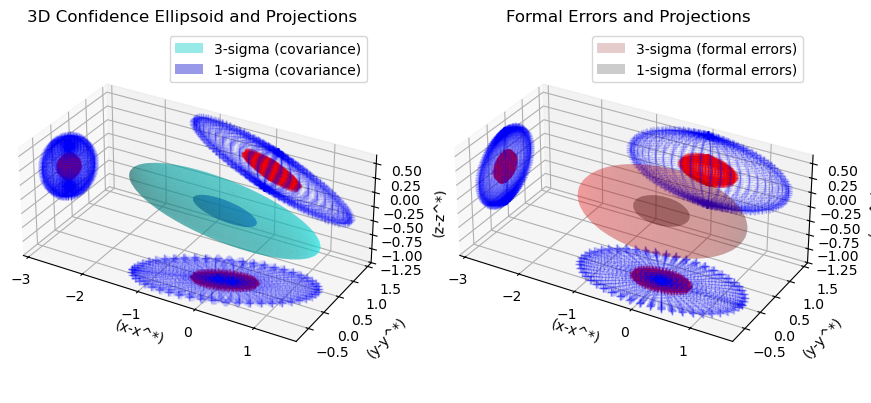

In [22]:
# # Select the first 3 dimensions for plotting

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(original_eigenvalues)[::-1]
diagonal_sorted_indices = np.argsort(original_diagonal_eigenvalues)[::-1]

eigenvalues = original_eigenvalues[sorted_indices]
eigenvectors = original_eigenvectors[:, sorted_indices]

diagonal_eigenvalues = original_diagonal_eigenvalues[diagonal_sorted_indices]
diagonal_eigenvectors = original_diagonal_eigenvectors[:, diagonal_sorted_indices]

# Output results
print(f"Sorted Eigenvalues (variances along principal axes):\n\n{eigenvalues}\n")
print(f"Sorted Formal Error Matrix Eigenvalues (variances along principal axes):\n\n{diagonal_eigenvalues}\n")
print(f"Sorted Eigenvectors (directions of principal axes):\n\n{eigenvectors}\n")
print(f"Sorted Formal Error Matrix Eigenvectors (directions of principal axes):\n\n{diagonal_eigenvectors}\n")

COV_sub = initial_covariance[np.ix_(np.sort(sorted_indices)[:3], np.sort(sorted_indices)[:3])]  #Covariance restriction to first 3 (spatial) eigenvectors
diagonal_COV_sub = diagonal_covariance[np.ix_(np.sort(diagonal_sorted_indices)[:3], np.sort(diagonal_sorted_indices)[:3])]  #Covariance restriction to first 3 (spatial) eigenvectors

x_star_sub = x_star[sorted_indices[:3]] #Nominal solution subset
diagonal_x_star_sub = x_star[diagonal_sorted_indices[:3]] #Nominal solution subset

# Eigenvalue decomposition of the submatrix
eigenvalues, eigenvectors = np.linalg.eig(COV_sub)
diagonal_eigenvalues, diagonal_eigenvectors = np.linalg.eig(diagonal_COV_sub)

# Ensure eigenvalues are positive
if np.any(eigenvalues <= 0):
     raise ValueError(f"$Covariance$ submatrix is not positive definite. Eigenvalues must be positive.\n")
if np.any(diagonal_eigenvalues <= 0):
    raise ValueError(f"$Formal Errors$ submatrix is not positive definite. Eigenvalues must be positive.\n")

phi = np.linspace(0, np.pi, 50)
theta = np.linspace(0, 2 * np.pi,50)
phi, theta = np.meshgrid(phi, theta)

# Generate points on the unit sphere and multiply each direction by the corresponding eigenvalue
x_ell= np.sqrt(eigenvalues[0])*  np.sin(phi) * np.cos(theta)
y_ell = np.sqrt(eigenvalues[1])* np.sin(phi) * np.sin(theta)
z_ell = np.sqrt(eigenvalues[2])* np.cos(phi)

# Generate points on the unit sphere and multiply each direction by the corresponding diagonal_eigenvalue
diagonal_x_ell = np.sqrt(diagonal_eigenvalues[0])*np.sin(phi) * np.cos(theta)
diagonal_y_ell = np.sqrt(diagonal_eigenvalues[1])*np.sin(phi) * np.sin(theta)
diagonal_z_ell = np.sqrt(diagonal_eigenvalues[2])*np.cos(phi)

ell = np.stack([x_ell, y_ell, z_ell], axis=0)
diagonal_ell = np.stack([diagonal_x_ell, diagonal_y_ell, diagonal_z_ell], axis=0)

#Rotate the Ellipsoid(s). This is done by multiplying ell and diagonal_ell by the corresponding eigenvector matrices
ellipsoid_boundary_3_sigma = 3 * np.tensordot(eigenvectors, ell, axes=1)
ellipsoid_boundary_1_sigma = 1 * np.tensordot(eigenvectors, ell, axes=1) 
diagonal_ellipsoid_boundary_3_sigma = 3 * np.tensordot(diagonal_eigenvectors, diagonal_ell, axes=1)
diagonal_ellipsoid_boundary_1_sigma = 1 * np.tensordot(diagonal_eigenvectors, diagonal_ell, axes=1)

# Plot the ellipsoid in 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121, projection='3d')
diagonal_ax =fig.add_subplot(122, projection='3d')

ax.plot_surface(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[1], ellipsoid_boundary_3_sigma[2], color='cyan', alpha=0.4, label = '3-sigma (covariance)')
ax.plot_surface(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[1], ellipsoid_boundary_1_sigma[2], color='blue', alpha=0.4, label = '1-sigma (covariance)')

diagonal_ax.plot_surface(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[1], diagonal_ellipsoid_boundary_3_sigma[2], color='red', alpha=0.2, label = '3-sigma (formal errors)')
diagonal_ax.plot_surface(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[1], diagonal_ellipsoid_boundary_1_sigma[2], color='black', alpha=0.2, label = '1-sigma (formal errors)')

ax.plot(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[2], 'r+', alpha=0.1, zdir='y', zs=2*np.max(ellipsoid_boundary_3_sigma[1]))
ax.plot(ellipsoid_boundary_1_sigma[1], ellipsoid_boundary_1_sigma[2], 'r+',alpha=0.1, zdir='x', zs=-2*np.max(ellipsoid_boundary_3_sigma[0]))
ax.plot(ellipsoid_boundary_1_sigma[0], ellipsoid_boundary_1_sigma[1], 'r+',alpha=0.1, zdir='z', zs=-2*np.max(ellipsoid_boundary_3_sigma[2]))

ax.plot(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[2], 'b+', alpha=0.1, zdir='y', zs=2*np.max(ellipsoid_boundary_3_sigma[1]))
ax.plot(ellipsoid_boundary_3_sigma[1], ellipsoid_boundary_3_sigma[2], 'b+',alpha=0.1, zdir='x', zs=-2*np.max(ellipsoid_boundary_3_sigma[0]))
ax.plot(ellipsoid_boundary_3_sigma[0], ellipsoid_boundary_3_sigma[1], 'b+',alpha=0.1, zdir='z', zs=-2*np.max(ellipsoid_boundary_3_sigma[2]))

diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[2], 'r+', alpha=0.1, zdir='y', zs=2*np.max(diagonal_ellipsoid_boundary_3_sigma[1]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[1], diagonal_ellipsoid_boundary_1_sigma[2], 'r+',alpha=0.1, zdir='x', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[0]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_1_sigma[0], diagonal_ellipsoid_boundary_1_sigma[1], 'r+',alpha=0.1, zdir='z', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[2]))

diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[2], 'b+', alpha=0.1, zdir='y', zs=2*np.max(diagonal_ellipsoid_boundary_3_sigma[1]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[1], diagonal_ellipsoid_boundary_3_sigma[2], 'b+',alpha=0.1, zdir='x', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[0]))
diagonal_ax.plot(diagonal_ellipsoid_boundary_3_sigma[0], diagonal_ellipsoid_boundary_3_sigma[1], 'b+',alpha=0.1, zdir='z', zs=-2*np.max(diagonal_ellipsoid_boundary_3_sigma[2]))

ax.set_xlabel('(x-x^*)')
ax.set_ylabel('(y-y^*)')
ax.set_zlabel('(z-z^*)')
ax.set_aspect('equal')
ax.set_title('3D Confidence Ellipsoid and Projections')
#ax.set_aspect('equal')
ax.legend(loc = 'upper right')

diagonal_ax.set_xlabel('(x-x^*)')
diagonal_ax.set_ylabel('(y-y^*)')
diagonal_ax.set_zlabel('(z-z^*)')
diagonal_ax.set_aspect('equal')
diagonal_ax.set_title('Formal Errors and Projections')
#diagonal_ax.set_aspect('equal')
diagonal_ax.legend(loc = 'upper right')

plt.subplots_adjust(left=1, right=2, top=0.9, bottom=0.1) 
plt.legend()
plt.show()